# Tutorial 2: Stochastic simulations 

This tutorial follows the first tutorial on Pairwise Invasibility
Plots. We will use the same model (from Claessen 2007). The objective
is to present stochastic simulations that allow to relax some
assumptions of adaptive dynamics and check its predictions.

*Concepts*: Stochastic simulations, TSS. 

## Biological problem

The adaptive dynamics framework allow us to make prediction about the
evolutionary trajectory of our system: i.e. the trajectory of the
heritable trait $u$ in a resident population at equilibrium, as it is
invaded by successive (initially rare) mutants.

Stochastic Simulations of individual based models (IBM) are a way to relax some modeling assumptions and see if they
still hold up when we introduce more complexity.

## Modeling the problem


We will use the assumptions introduced in the main lecture:

-   Haploid asexual populations,
-   Each individual characterized by a trait $u \in [0,1]$.
-   Each individual have a birth rate $b$ and a death rate $d$.
-   Each time an individual reproduce, it spawns a individual with the
    same trait $u$ than its parent with probability $(1-\mu)$ or a
    mutated trait $u+\epsilon(u)$ with probability $\mu$. $\epsilon(u)$
    is a normal random variable centered on $u$ and clamped so
    $u+\epsilon(u) \in [0,1]$ a.s.

So we have a set of individuals that give birth and die. 

The **state** of our population at any time $t$ is $(u_i)_{i=1...N_t} \in \mathbb [0,1]^N_t$ where $N_t$ is the number of individuals in the population at time $t$. Notice how it is different than in the ODE from the previous tutorial.

We will model the dynamics of our system by a *continuous time Markov Process*. I will not go into more mathematical details than necessary. If you want a formal introduction to continuous time Markov Processes, you should have a look at the lecture Math02 in the biology department.   

### Simple case
Let us imagine that we have one individual, $b>0$, $d=0$. The only thing that can happen now is that this individual will reproduce. 

We use a random variable to model the time before which we have two individuals. This random variable follow the **Exponential distribution**.

\begin{equation*}
X \sim \mathcal {E} \text{xp}(\lambda)
\Rightarrow
\begin{cases}
\mathbb P(X \in A  ) = \int_A \lambda e^{-\lambda x} dx\\
\mathbb E(x) = \frac{1}{\lambda}
\end{cases}
\end{equation*}

---- 
Exponential variables have two important properties that will be usefull later:

**Memorylessness** :
$\mathbb P(X>s+t | X>s) = \mathbb P(X>t)$

**Law of the minimum of independent exponential variables:**   

\begin{equation*}
\begin{cases}
X_i \sim \mathcal Exp(\lambda_i), \\
Y_i=\min_i X_i, \\ Z_i = 
\text{argmin}_i X_i 
\end{cases}
\Rightarrow
\begin{cases}
Y \sim \mathcal Exp(\sum_i \lambda_i) \\
\mathbb P(Z=i) = \frac{\lambda_i}{\sum_j \lambda_j}
\end{cases}
\end{equation*}
These are quite easy to prove from the definition of the exponential
distribution. If you have never done the proof, give it a try.

----


Thus, after a time $T_0 \sim \mathcal Exp =(b)$ the population has two individuals. The next event to occur is that either individual reproduce. The time before the next event is the minimum of two exponential variables with parameter $b$. 

# Simulations


## Exact stochastic simulation

Let us consider a first way to simulate our process, the naïve *Doob-Gillespie Stochastic Simulation Algorithm* (SSA), also known as *Kinetic Monte Carlo*. 

The core idea of the algorithm is to always compute which is the next event to occur,
apply it and rinse and repeat.

Here is the pseudo-code:

    #Initialize a data structure to store all individuals and their traits.
    t = 0
    while t<T:
        #Compute all the birth/death rates.
        #Sample from the exponential distribution the time of the next event dt.
        t += dt
        #Sample from a multinomial distribution the identity of the next event.
        #if it it a birth event, manage the eventual mutation
        #Update the list of individuals

Notice how the two properties of Exponential variable come into play !

The problem with this algorithm is that it is really slow for large
population sizes. You need to sample two random number at each event and
recompute all the rates. We have to find a better way.

Ref: Gillespie, Daniel T. “A General Method for Numerically Simulating the Stochastic Time Evolution of Coupled Chemical Reactions.” Journal of Computational Physics 22, no. 4 (1976): 403–434.



## Approximate Stochastic Simulations

### Reducing the state space.


You would have noticed that I was staying quite vague about the data
structure that holds the population. Of course, having a long list with
all the individuals is not efficient. It is much better to have a small
state space.

Let us come back on the assumption of the adaptive dynamics: the
mutations are rare enough so that the population is essentially
dimorphic: a resident and mutant at all time. 

We can take $\mathbb N^2_+$ as the state space. So at all point in time we just have
to store the value of the resident and mutant trait and the number of
individuals. 

Extra mutation are ignored. If the mutation rate is high enough this can significantly impact the correctness of our simulation. 

More generally we can decide to limit the number of simultaneous trait values in the population to $M\in \mathbb N$, and use $\mathbb N^M_+$ as the state space. This is what I've done in the following simulations. 

### Discrete time integration

Instead of simulating every single event, we could "integrate" what  happen over a small time window. 

We consider a small integration time $dt$, over which the birth-death process have constant birth and death rates
$b$ and $d$. 

Note that the algorithm is not exact anymore ! We are doing an **approximate stochastic simulation**.


    t = 0
    pop = init_pop()
    while t < T:
      # increase the time
      t += dt
      # Compute the new birth/death rates.
      b,d = get_birth_death_rate(pop)
      # Compute the new population size after dt based on the constant rates.
      pop = birth_death_discrete(pop,b,d,dt)

#### Poisson's approximation of growth.

A very fast (but loose) method to do this is too use a Poisson distribution to estimate directly not only the number of events, but the whole population size after $dt$. 

$$ 
n_{t+dt} \sim Poisson(n_t e^{(b-d)dt})
$$

Note that on average, we get $n_{t+dt} = n_t e^{(b-d)dt}$ individuals, which is
coherent with the $\frac{dN}{dt} = N (b-d)$ differential equation with
initial condition $N(t)=n_t$. 

Moreover, when dt tends toward 0 we have:

\begin{align}
n_{t+dt} - n_t &= n_t (e^{(b-d)dt} - 1)\\
&\approx n_t (b-d)dt &(\text{1st order Taylor expansion})
\end{align}

This method is described in Zen's reference manual as "Non mathematically rigorous though [producing] satisfactory results" (p 10). I used this one in the code below.  

An advantage is that this method cannot yield negative population size, whereas the tau-leap can.

#### Tau-leap

The tau-leap algorithm (Gillespie, 2001) approximate the number of event during $dt$ with a Poisson distribution:

If we have a collectition of individuals with $n_i$ individual carrying a constant birth rate $b_i$, the number of birth during dt is: 

$$ 
B \sim Poisson \left ( dt \sum n_i b_i \right)
$$

Conversely,
$$ 
D \sim Poisson \left( dt \sum n_i d_i \right) 
$$

Hence:

\begin{equation}
n_{t+dt} = n_t + B - D
\end{equation}

on averarge

\begin{equation}
\mathbb E (n_{t+dt} - n_t) = \sum n_i (b_i-d_i) dt
\end{equation}

----
*Proof for a simple case*: 

Let us consider a pure birth process $b>0, d=0$ with $n_t$ individuals at time $t$.

Let $P(k, bn_0, t)$ be the probability that $k$ birth event take place during $[0,t]$.


The probability that no event occur before $t$ ($k=0$) is given by the distribution of $T \sim \mathcal Exp(bn_0)$ the time of the first event:

\begin{align}
P(0, bn_0,t) = P(T>t) &= 1 - \int_0^t bn_0 e^{-bn_0x} dx \\
&= e^{-bn_0t}
\end{align}

Moreover, we have $\forall k \geq 1$:

\begin{align}
P(k, bn_0, t) &= \int_0^t P(k-1, bn_0, x) P(1, bn_0, t-x) dx \\
 &= \int_0^t P(k-1, bn_0, x) bn_0 e^{-bn_0(t-x)} dx \\
 &= bn_0 \int_0^t P(k-1, bn_0, x)  P(0,bn_0,t-x) dx 
\end{align}

By induction we can show that: 

$$
P(k, b_n0, t) = \frac{e^{-bn_0t} (bn_0t)^k}{k!}
$$

Meaning that the number of birth events during $[0,t]$ follow a Poisson distribution with parameter $bn_0t$.

---- 

Ref: Gillespie, Daniel T. “Approximate Accelerated Stochastic Simulation of Chemically Reacting Systems.” The Journal of Chemical Physics 115, no. 4 (July 12, 2001): 1716–33. https://doi.org/10.1063/1.1378322.

In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from itertools import chain
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm
%matplotlib inline

In [2]:
def discrete_bdm_process(T, steps, skip, state,
                         phenotypes, mutation_rate,
                         mutation_effect, get_rates,
                         umin=0, umax=1):
    """ Perform a stochastic simulation of the birth-death process with mutations. 
    
    Args:
        T (float): Final time. The process is simulated on [0,T].
        steps (int): number of time division. 
        skip (int): only save one every `skip` state
        state (np.array of int): the number of individual of each type.
        phenotypes (np.array of floats): the value of the trait of each type.       
        get_rates (function): a functio that maps state,phenotypes to a list of growth rate. (ecological model).
        
    Returns:
        trajectory (np.array of int, shape= (len(state), steps)) 
        pheno_traj (np.array of floats, shape= (len(state), steps)) 
    """
    M = len(state) # number of different phenotypes
    
    # Initialize the data structure for the trajectory 
    trajectory = np.zeros((M,steps//skip), dtype=int)
    pheno_traj = np.zeros((M,steps//skip))
    trajectory[:,0] = state
    pheno_traj[:,0] = phenotypes
    new_state = np.zeros(M)
    tlist = np.zeros(steps//skip)
    dt = T/steps 
    for t in range(1,steps):
        # at each time step we compute the new rates
        rates = get_rates(phenotypes, state)
        nmutants = np.zeros(M, dtype=int)
        
        # for each type, we compute the new number of individuals, and the number of mutants.
        for i in range(M):        
            if state[i]:
                new_state[i] = np.random.poisson(state[i]*np.exp(rates[i]*dt))
                birth = new_state[i] - state[i]
                if birth>0:
                    nmutants[i] = np.random.binomial(birth, mutation_rate)
        
        # Treat the mutations. 
        if mutation_rate and nmutants.sum(): 
            
            # Create a list that contains the index of the phenotype of 
            # every individual that mutated during the last time interval.
            # i.e. if nmutant = [1,3,2], parent_list = [0,1,1,1,2,2].
            parent_list = list(chain(*[[i]*n for i,n in enumerate(nmutants)]))
            
            # List the empty phenotype slots, this is where we will put the mutants.
            mutants_list = np.arange(M)[state==0]
                        
            # If we have too many potential parents compared to the number of open slots 
            # for phenotype, we select them uniformely at random.
            # Note: this is quit an important restriction of our simulation !
            if len(parent_list) > len(mutants_list):
                parent_list = np.random.choice(parent_list, size=len(mutants_list),replace=False)
                
            # Go through the mutations and do the mutation. 
            for pos_parent, pos_mutant in zip(parent_list, mutants_list):
                phenotypes[pos_mutant] = np.clip(phenotypes[pos_parent] + np.random.normal(0,mutation_effect),umin,umax)
                new_state[pos_mutant] = 1
                new_state[pos_parent] -= 1
                
        # We copy the content of new_state in state. 
        state[:] = new_state[:]
        
        # We save once in a while. 
        if t%skip == 0:
            trajectory[:,t//skip] = state
            pheno_traj[:,t//skip] = phenotypes
            tlist[t//skip] = t*dt
    return trajectory, pheno_traj, tlist


In [3]:
def claessen2007(ulist, nlist, a1, a2, b1,b2, d1, d2, K1, K2,mu,V):
    """Return the growth rate from the model in Claessen 2007."""
    density = nlist / V
    A1 = lambda u: a1 + u*b1
    A2 = lambda u: a2 + u*b2 
    F1 = (d1*K1)/(np.sum([A1(u)*u*N for u,N in zip(ulist,density)]) + d1)
    F2 = (d2*K2)/(np.sum([A2(u)*(1-u)*N for u,N in zip(ulist,density)])  + d2)
    bet = lambda u: (F1 * A1(u) * u) + (F2 * A2(u) * (1-u)) - mu
    return np.array([bet(u) for u in ulist])

def estimate_nstar( a1, a2, b1,b2, d1, d2, K1, K2,mu,V):
    return (d1*K1+d2*K2)/mu

p_common = {"b2":0, 'd1':1,'d2':1,'K1':1,'K2':1,'mu':0.1,'V':100}
p_neutral = {"a1": 1, "b1": 0, "a2":1, **p_common}
p_strong = {"a1": 1, "b1": 1, "a2":2, **p_common}
p_weak = {"a1": 2, "b1": -1, "a2":1, **p_common}

In [4]:
def plot_density(traj, ptraj, tlist, ustep=300, ax=None):
    dist = np.zeros((ustep-1,traj.shape[1]+1))
    bin_min, bin_max = ptraj.min(), ptraj.max()
    bins = np.linspace(bin_min, bin_max, ustep)
        
    for t, traits in enumerate(ptraj.transpose()):
        dist[:,t], _ = np.histogram(traits, weights=traj[:,t], bins=bins)

    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(20,5))
    dmask = dist
    dmask[dmask==0] = np.nan
    mp = ax.imshow(dmask,aspect='auto', 
                   extent=[tlist.min(),tlist.max(),bin_min, bin_max],
                   cmap='viridis',
                   origin='bottom')
    ax.set(xlabel='Time',ylabel='Trait')
    cax = make_axes_locatable(ax).append_axes("right", size="1%", pad=0.1)
    ax.get_figure().colorbar(label='density', cax=cax, ax=ax, mappable=mp)
    
def plot_stack(traj, ptraj, tlist, ax=None, lw=0.3, color_over=100):
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(20,5))
    bin_min, bin_max = ptraj.min(), ptraj.max()
    transform = lambda x : (x - bin_min) / (bin_max - bin_min)
    df = np.cumsum(traj,axis=0)
    ax.fill_between(tlist, np.zeros_like(df[0]), df[-1], color='grey')
    for i, (y1, y2) in enumerate(zip(chain([np.zeros_like(df[0]),], df[:-1]), df)):
        bkpts = np.nonzero(ptraj[i,:-1] != ptraj[i,1:])[0]
        for t0,t1 in zip(chain([0,], bkpts), chain(bkpts, [ptraj.shape[1],])):
            t = (t0+t1)//2
            if t0-t1 and np.max(y2[t0:t1]-y1[t0:t1]) > color_over :
                ax.fill_between(tlist[t0:t1],  y1[t0:t1], y2[t0:t1],
                                color=matplotlib.cm.viridis(transform(ptraj[i,t])))
        ax.plot(tlist, y2, color='k', lw=lw)

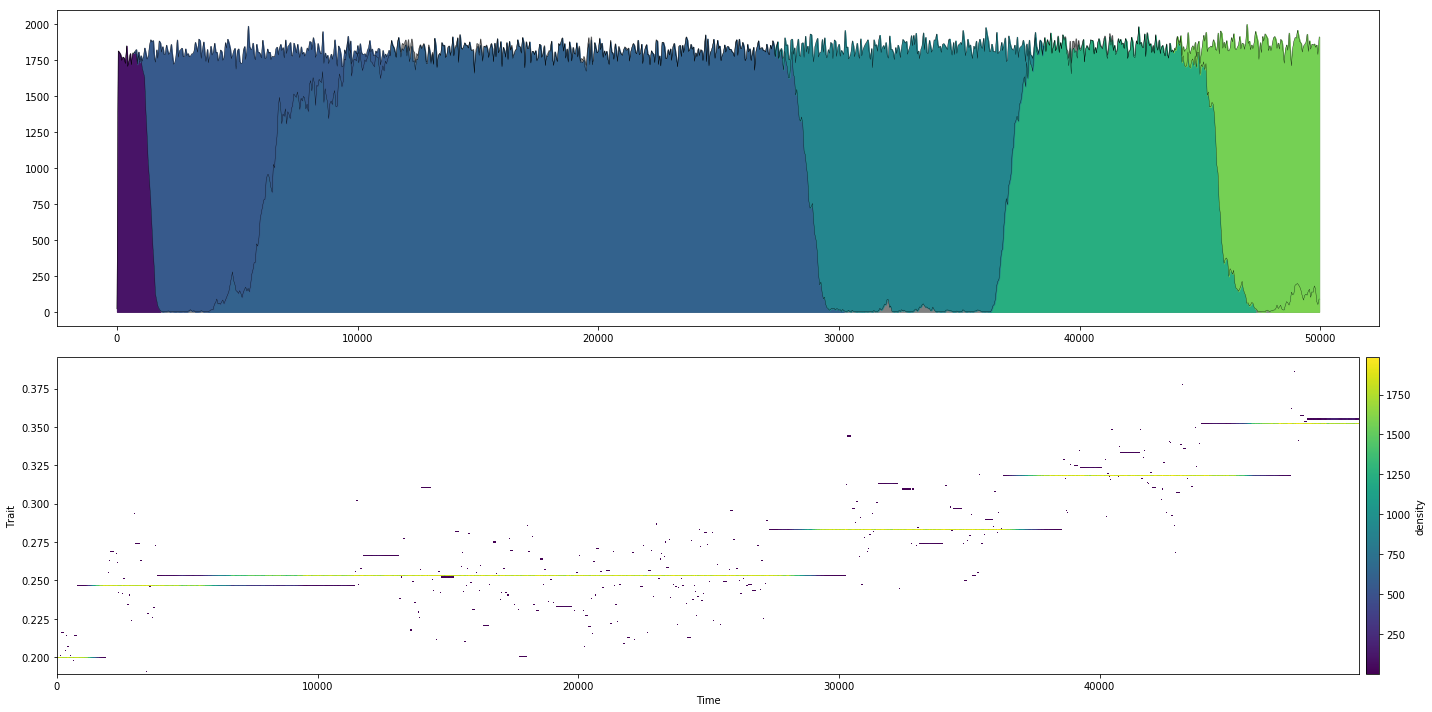

In [5]:
M = 1
traj, ptraj, tlist = discrete_bdm_process(T=50000, 
                                           steps=10000,
                                           skip=10,
                                           state=np.array([estimate_nstar(**p_strong)]+[0]*M,dtype=int),
                                           phenotypes=np.array([0.2]*(M+1)),
                                           mutation_rate=0.1,
                                           mutation_effect=0.02,
                                           get_rates=partial(claessen2007, **p_strong))
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20,10))
plot_stack(traj,ptraj, tlist,ax=ax1)
plot_density(traj, ptraj, tlist,ax=ax2)
plt.tight_layout()
plt.savefig('trajectory.png',bbox_inches='tight')

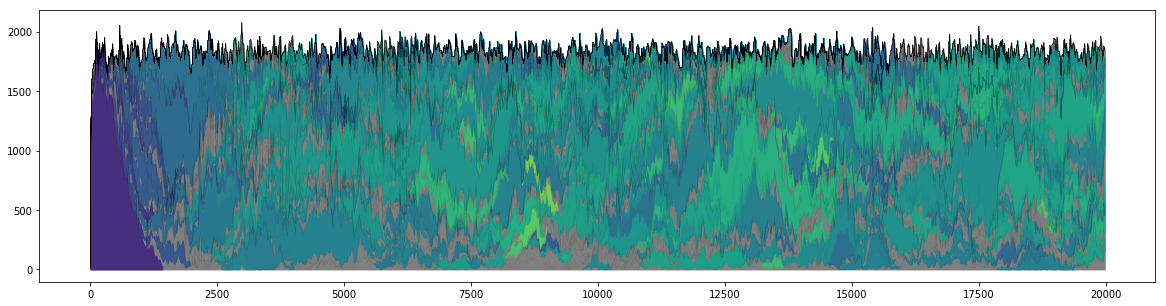

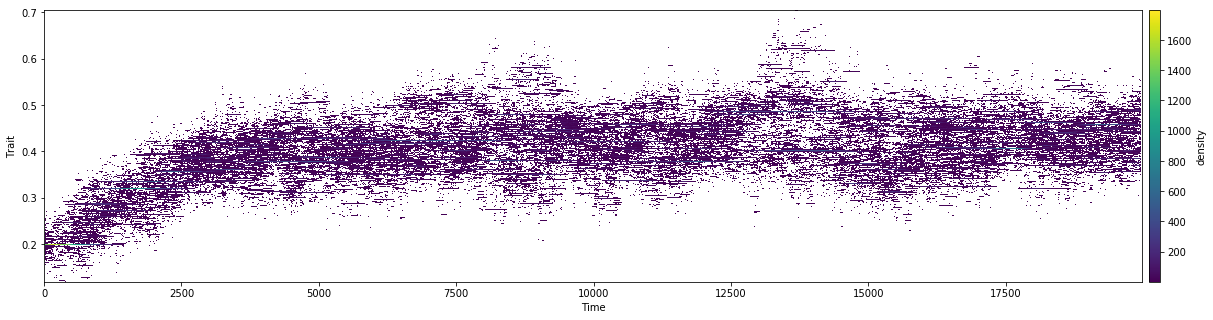

In [6]:
M = 200
traj, ptraj, tlist = discrete_bdm_process(T=20000, 
                                           steps=10000,
                                           skip=10,
                                           state=np.array([estimate_nstar(**p_weak)]+[0]*M,dtype=int),
                                           phenotypes=np.array([0.2]*(M+1)),
                                           mutation_rate=0.1,
                                           mutation_effect=0.02,
                                           get_rates=partial(claessen2007, **p_weak))
plot_stack(traj, ptraj, tlist, lw=0.01)
plot_density(traj, ptraj, tlist)

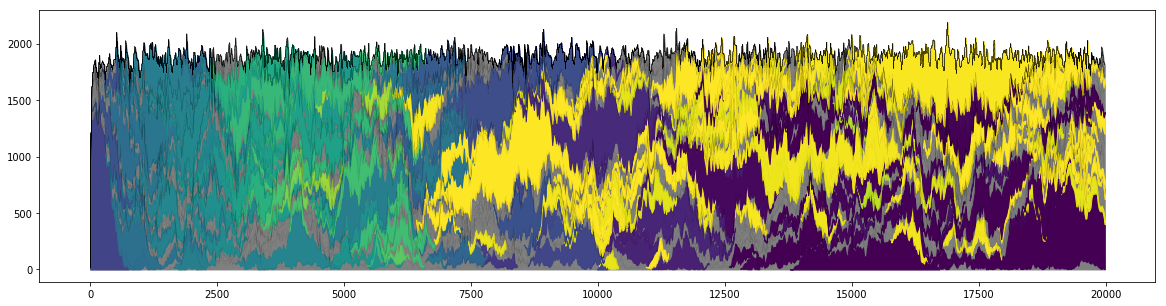

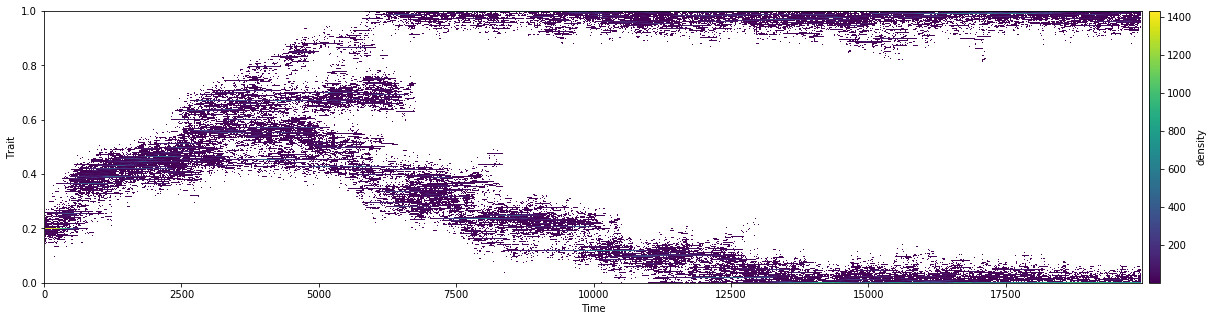

In [7]:
M = 200
traj, ptraj, tlist = discrete_bdm_process(T=20000, 
                                           steps=10000,
                                           skip=10,
                                           state=np.array([estimate_nstar(**p_strong)]+[0]*M,dtype=int),
                                           phenotypes=np.array([0.2]*(M+1)),
                                           mutation_rate=0.1,
                                           mutation_effect=0.02,
                                           get_rates=partial(claessen2007, **p_strong))
plot_stack(traj, ptraj, tlist, lw=0.01)
plot_density(traj, ptraj, tlist)